In [15]:
#### COMBINES W2V + LINEAR SVC AND OUTPUTS A HEATMAP
#### SEPARATES W2V OF TRAINING SAMPLE FROM W2V OF TEST SAMPLE AS IF KEYWORDS IN TEST SAMPLE ARE UNSEEN AND THUS NOT USED WHEN CREATING VOCABULARY
#### CAN BE USED WITH EITHER 'cleanFocusCategory' or 'cleanFocusParentCategory'


import json
import pandas as pd
# Opening JSON file
f = open('/home/ferdinand_t/data/CMS_2010_to_June_2022_ENGLISH.json')
# returns JSON object as
# a dictionary
data = json.load(f)
df = pd.DataFrame.from_dict(data)
# df['cleanLastModifiedDate'] = pd.to_datetime(df['lastModifiedDate'])
# df.set_index('cleanLastModifiedDate', inplace = True)
# df.sort_index().head()


In [21]:
#df['firstKeyword'] = df['keywords'].apply(lambda x: x[0]['name'] if len(x) != 0 else None)
# #df['secondKeyword'] = df['keywords'].apply(lambda x: x[1]['name'] if len(x) > 1 else None)
# #df['thirdKeyword'] = df['keywords'].apply(lambda x: x[2]['name'] if len(x) > 2 else None)
# #df['fourthKeyword'] = df['keywords'].apply(lambda x: x[3]['name'] if len(x) > 3 else None)

#df['cleanFocusCategory'] = df['thematicFocusCategory'].apply(lambda x: x['name'] if x is not None else x)
#df['cleanLastModifiedDate'] = pd.to_datetime(df['lastModifiedDate'])
# #df = df[['firstKeyword', 'secondKeyword', 'thirdKeyword', 'fourthKeyword', 'thematicFocusCategory', 'cleanFocusCategory']]

df = df[['keywordStrings', 'thematicFocusCategory']]

df_clean = df.copy()
df_clean = df_clean.dropna()
# df_clean['cleanKeywordStrings'] = [' '.join(map(str, l)) for l in df_clean['keywordStrings']]

In [22]:
df_clean.columns

Index(['keywordStrings', 'thematicFocusCategory'], dtype='object')

In [16]:
def clean_categories(df):
    ''' 
    Cleans the category column of data frame df
    1. Gets rid of the dictionary format
    2. Extracts all the main (primary) categories

    '''

    # Makes a new column to get rid of the dictionary format
    df['cleanFocusCategory'] = df['thematicFocusCategory'].apply(lambda x: x['name'] if x is not None else x)

    # Convert all secondary categories into primary categories
    children_dict = {'Architecture':'Culture', 'Design':'Culture', 'Film':'Culture', 'Arts':'Culture', 
                    'Literature':'Culture', 'Music':'Culture', 'Dance':'Culture', 'Theater':'Culture',
                    'Climate':'Nature and Environment',
                    'Conflicts':'Politics', 'Terrorism':'Politics', 
                    'Corruption':'Law and Justice', 'Crime':'Law and Justice', 'Rule of Law':'Law and Justice',
                        'Press Freedom':'Law and Justice', 
                    'Diversity':'Human Rights', 'Freedom of Speech':'Human Rights', 'Equality':'Human Rights', 
                    'Soccer': 'Sports',
                        'Trade':'Business', 'Globalization':'Business', 'Food Security':'Business'
    }

    secondary_cts = [val for val in children_dict.keys()]

    # Replaces
    df['cleanFocusParentCategory'] = df['cleanFocusCategory'].apply(lambda x: children_dict[x] if x in secondary_cts else x)

    return df

In [23]:
df_clean = clean_categories(df_clean)

In [3]:
import gensim
from gensim.models import Word2Vec

wv = gensim.models.KeyedVectors.load_word2vec_format("/home/ferdinand_t/Downloads/GoogleNews-vectors-negative300.bin", binary=True)

In [24]:
# Count vectorization of text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
corpus_train, corpus_test, label_train, label_test, indices_train, indices_test = train_test_split(df_clean['keywordStrings'], df_clean['cleanFocusParentCategory'], df_clean.index, test_size=0.33, random_state=0) 
# Ticket Data
corpus = corpus_train.astype(str)
 
# Creating the vectorizer
vectorizer = CountVectorizer(stop_words='english')
 
# Converting the text to numeric data
X = vectorizer.fit_transform(corpus)
 
#print(vectorizer.get_feature_names())
# Preparing Data frame For machine learning
# Priority column acts as a target variable and other columns as predictors
CountVectorizedData=pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
CountVectorizedData['cleanFocusParentCategory']= label_train.values
print(CountVectorizedData.shape)
CountVectorizedData.head()

(53541, 31881)


/home/ferdinand_t/venv/lib64/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,000,007,01,03,04,05,08,0rg,10,100,...,özil,özlem,özoguz,øystein,út,überall,ünal,ünker,żurek,cleanFocusParentCategory
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Politics
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Politics
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Politics
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Politics
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Politics


In [25]:
WordsVocab=CountVectorizedData.columns[:-1]

In [26]:
import numpy as np
X_corpus_train = vectorizer.transform(corpus_train.astype(str))
CountVecData=pd.DataFrame(X_corpus_train.toarray(), columns=vectorizer.get_feature_names())
    
    # Creating empty dataframe to hold sentences
W2Vec_Data_temp=pd.DataFrame()
    
Sentence_1=[[wv[word] if word in wv.key_to_index.keys() else np.zeros(300) for word in WordsVocab[CountVecData.iloc[i , :]>=1]] for i in range(CountVecData.shape[0])]
W2Vec_Data_temp=W2Vec_Data_temp.append(pd.DataFrame(Sentence_1))
Sentence_2=[[wv[word.capitalize()] if word.capitalize() in wv.key_to_index.keys() and word not in wv.key_to_index.keys()  else np.zeros(300) for word in WordsVocab[CountVecData.iloc[i , :]>=1]] for i in range(CountVecData.shape[0])]
W2Vec_Data_temp=W2Vec_Data_temp.append(pd.DataFrame(Sentence_2))
test_sum_df = W2Vec_Data_temp.groupby(W2Vec_Data_temp.index).sum()
#W2Vec_Data = test_sum_df.sum(axis=1)
test_sum_df[test_sum_df.applymap(lambda x: np.allclose(x, 0))] = np.nan
W2Vec_Data = test_sum_df.apply(lambda x: np.mean(x[x.notnull()]), axis=1)
W2Vec_Data_df = pd.DataFrame(W2Vec_Data)
W2Vec_Data_df_final = W2Vec_Data_df[0].apply(pd.Series)
W2Vec_Data_corpus_train = W2Vec_Data_df_final

/home/ferdinand_t/venv/lib64/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [27]:
#TODO THEN I DONT HAVE TO CREATE THE DATAFRAME BEFORE THAT STEP
# Adding the target variable
W2Vec_Data_corpus_train.reset_index(inplace=True, drop=True)
W2Vec_Data_corpus_train['cleanFocusParentCategory']=label_train.values
 
# Assigning to DataForML variable
DataForML_corpus_train=W2Vec_Data_corpus_train
DataForML_corpus_train.loc[DataForML_corpus_train.isna().any(axis=1),0:299] = 0
DataForML_corpus_train.shape

(53541, 301)

In [28]:
# Separate Target Variable and Predictor Variables
TargetVariable_corpus_train=DataForML_corpus_train.columns[-1]
Predictors_corpus_train=DataForML_corpus_train.columns[:-1]
 
X_corpus_train=DataForML_corpus_train[Predictors_corpus_train].values
y_corpus_train=DataForML_corpus_train[TargetVariable_corpus_train].values

In [29]:
import numpy as np
X = vectorizer.transform(corpus_test.astype(str))
CountVecData=pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
    
    # Creating empty dataframe to hold sentences
W2Vec_Data_temp=pd.DataFrame()
    
Sentence_1=[[wv[word] if word in wv.key_to_index.keys() else np.zeros(300) for word in WordsVocab[CountVecData.iloc[i , :]>=1]] for i in range(CountVecData.shape[0])]
W2Vec_Data_temp=W2Vec_Data_temp.append(pd.DataFrame(Sentence_1))
Sentence_2=[[wv[word.capitalize()] if word.capitalize() in wv.key_to_index.keys() and word not in wv.key_to_index.keys()  else np.zeros(300) for word in WordsVocab[CountVecData.iloc[i , :]>=1]] for i in range(CountVecData.shape[0])]
W2Vec_Data_temp=W2Vec_Data_temp.append(pd.DataFrame(Sentence_2))
test_sum_df = W2Vec_Data_temp.groupby(W2Vec_Data_temp.index).sum()
#W2Vec_Data = test_sum_df.sum(axis=1)
test_sum_df[test_sum_df.applymap(lambda x: np.allclose(x, 0))] = np.nan
W2Vec_Data = test_sum_df.apply(lambda x: np.mean(x[x.notnull()]), axis=1)
W2Vec_Data_df = pd.DataFrame(W2Vec_Data)
W2Vec_Data_df_final = W2Vec_Data_df[0].apply(pd.Series)
W2Vec_Data = W2Vec_Data_df_final

In [30]:
#TODO THEN I DONT HAVE TO CREATE THE DATAFRAME BEFORE THAT STEP
# Adding the target variable
W2Vec_Data.reset_index(inplace=True, drop=True)
W2Vec_Data['cleanFocusParentCategory']=label_test.values
 
# Assigning to DataForML variable
DataForML=W2Vec_Data
DataForML.loc[DataForML.isna().any(axis=1),0:299] = 0
DataForML.shape

(26372, 301)

In [31]:
# Separate Target Variable and Predictor Variables
TargetVariable=DataForML.columns[-1]
Predictors=DataForML.columns[:-1]
 
X=DataForML[Predictors].values
y=DataForML[TargetVariable].values

In [32]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

model = LinearSVC()
model.fit(X_corpus_train, y_corpus_train)
y_pred = model.predict(X)
accuracy_score(y,y_pred)

0.723342939481268

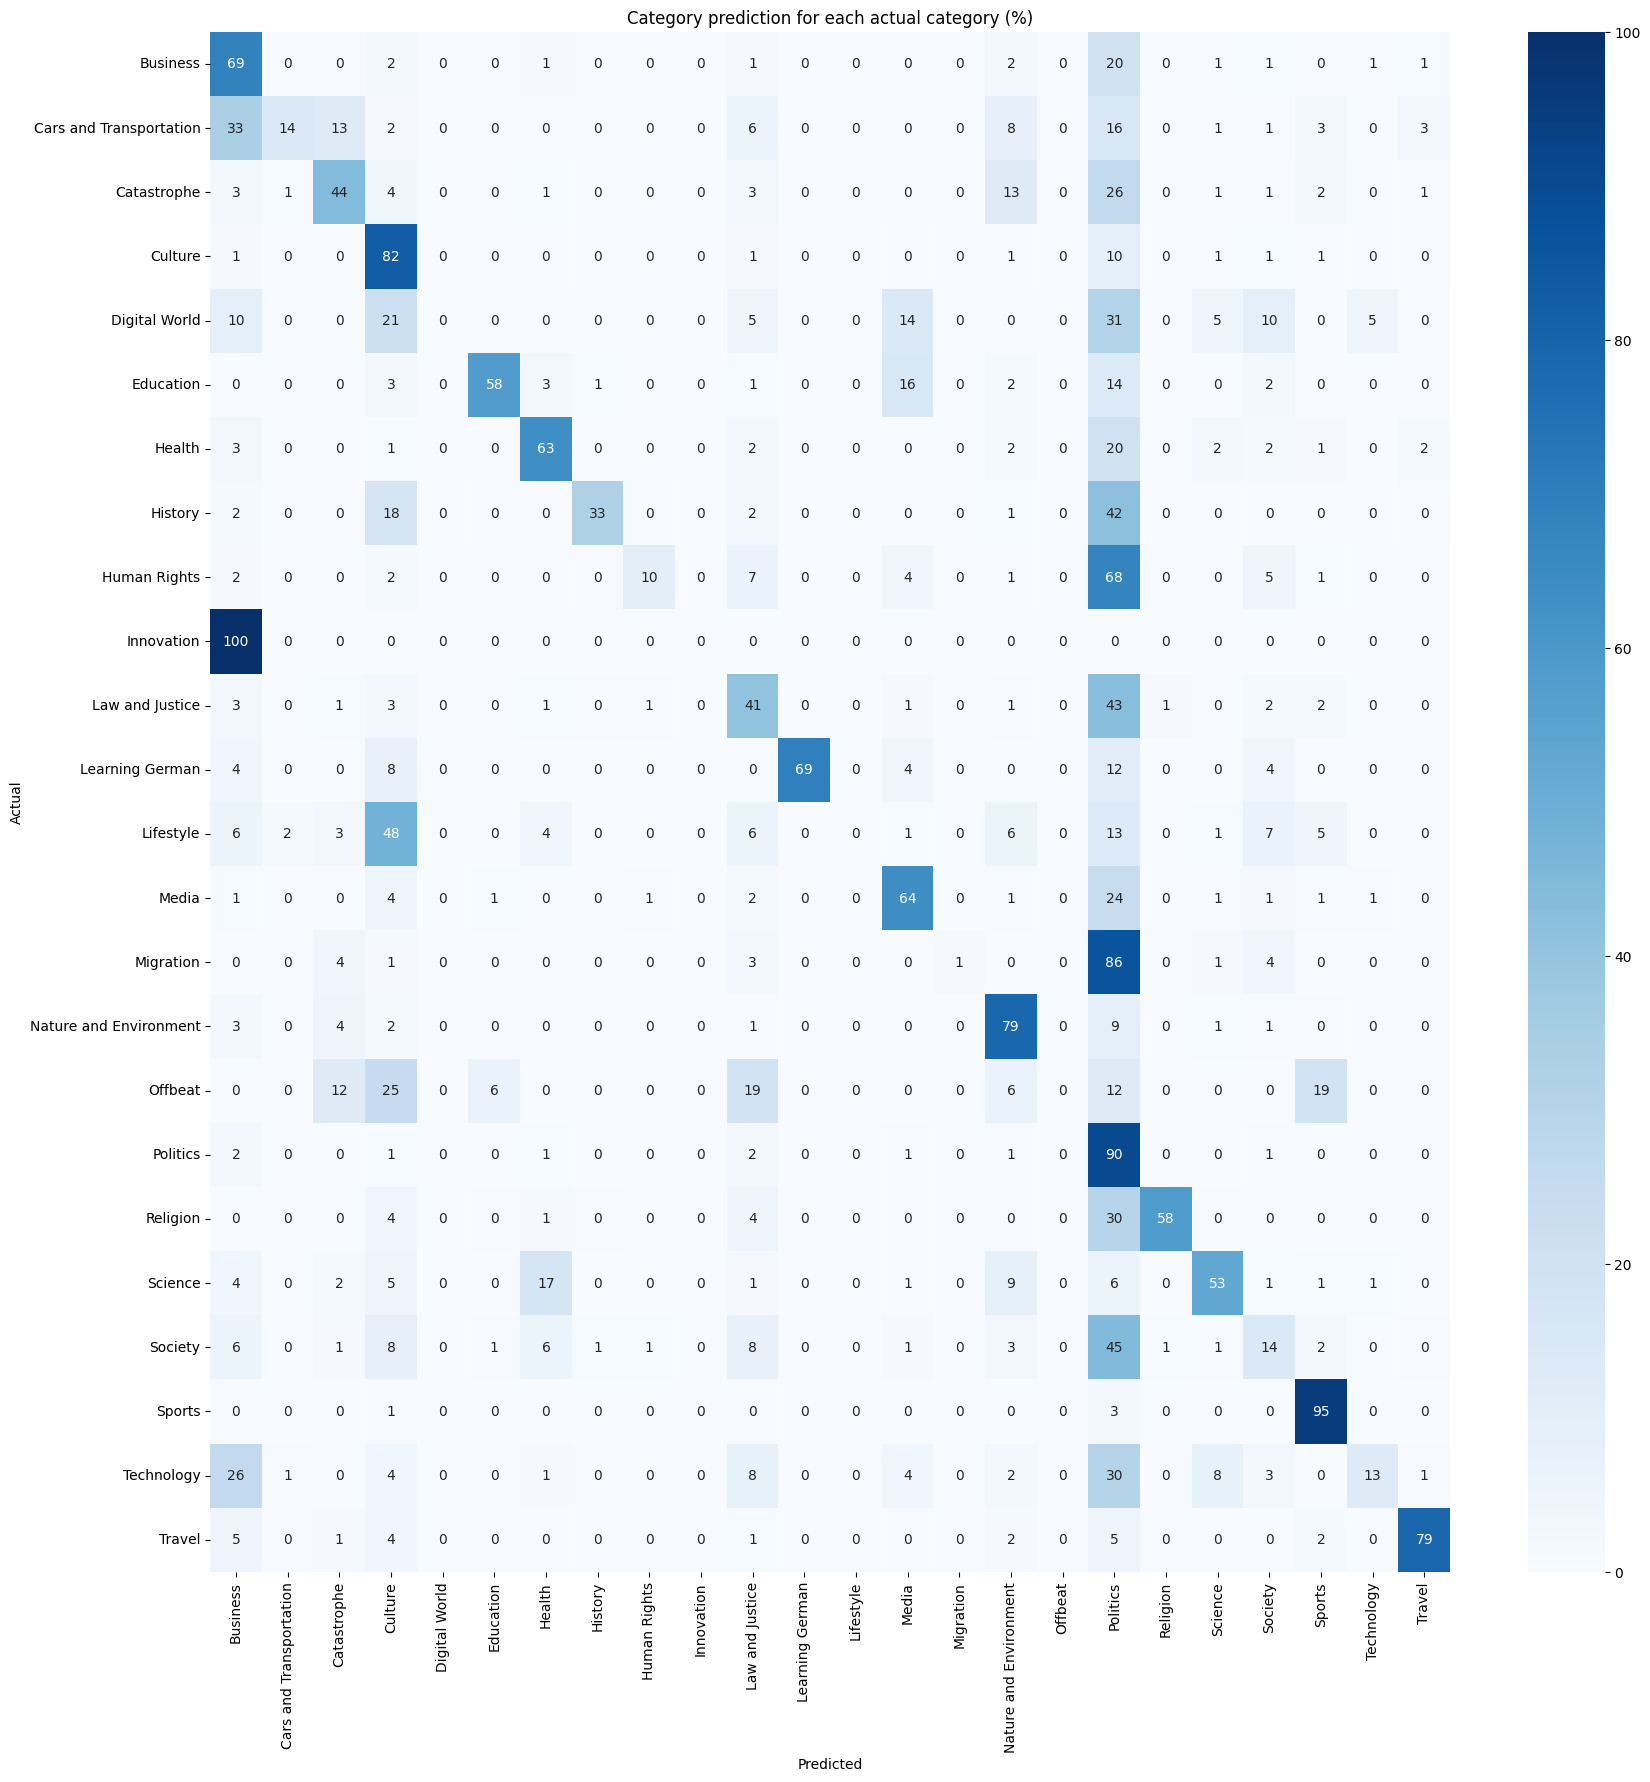

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
category_id_df=df_clean['cleanFocusParentCategory'].drop_duplicates().sort_values() #result['dw_cat'].drop_duplicates().sort_values() #data #count_values_for_columns(result)['dw_cat'].index

#y_test= df_all['dw_cat'] #count_values_for_columns(df_single)['dw_cat'].values
#y_pred = dw_result.reset_index()[1].explode() #count_values_for_columns(result)[1].index

from sklearn.metrics import confusion_matrix


conf_mat = confusion_matrix(y, y_pred)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(100*conf_mat/conf_mat.sum(axis=1)[:,None], annot=True, fmt='.0f', cmap='Blues', xticklabels=category_id_df.values, yticklabels=category_id_df.values)
#sns.heatmap(conf_mat, annot=True, xticklabels=category_id_df.values, yticklabels=category_id_df.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Category prediction for each actual category (%)')
plt.show()